In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data_sk/data02.csv')

# みんなとは違うデータでやってみたいなら次のファイルを読み込んでください。結果が変わります。
# data = pd.read_csv('data_sk/data03.csv')

中を見てみましょう

In [ ]:
data

`recoMom_GeV` 観測データから再構成された荷電粒子（e or μ）の運動量 \[GeV\]

`recoCosz` 再構成された荷電粒子の cos(天頂角). +1は鉛直上から来た粒子、0は地平線方向、-1は地球の反対側（下）から来た粒子

`recoPidParam` 再構成された荷電粒子のμらしさ。>0でよりμらしく、<0でよりeらしい。

In [ ]:
data[data['recoMom_GeV'] < 10.].hist('recoMom_GeV', bins=100);
plt.xlabel('Reconstructed momentum [GeV]');

In [ ]:
data.plot.scatter(x='recoMom_GeV', y='recoCosz', s=0.1, alpha=0.2);
plt.xscale('log');
plt.xlabel('Reconstructed momentum [GeV]')
plt.ylim(-1., 1.);

In [ ]:
data.plot.scatter(x='recoMom_GeV', y='recoPidParam', s=0.1, alpha=0.2);
plt.xscale('log');
plt.xlabel('Reconstructed momentum [GeV]')
plt.ylabel('Reconstructed μ-likeness')
plt.ylim(-1e4, 1e4);

二つの枝に別れていますが、これは見ているものが離散的に異なる状態（ここでは異なる粒子）、であると考えられます。縦軸は「μらしさ」なので、上がμ、下がeでしょう。問題は1GeV以下でこれらが重なっている点で、後でシミュレーションを使いますが、シミュレーションが正確でないとこのあたりの混ざっている領域は実験結果の系統的な誤差となってしまいます（実は本当はもっとずっと綺麗に分かれるのですが、ここではこういう効果の勉強のためにあえて悪くしています）。なので綺麗に別れているところだけを使うことにして、1.5GeV以上のイベントをMulti-GeV、1.5GeV以下のイベントをSub-GeVとし、今回の解析ではMulti-GeVのみを使うことにします。ちょっと違う値で切っても大丈夫です。あとでやりますが、Multi-GeVの方が天頂角の再構成精度もいいので、ニュートリノ振動がより綺麗に見えます。

In [ ]:
from enum import Enum, unique

# Enum を pandas に入れるときに < が出来ないとエラーを吐かれたりするので
class SortableEnum(Enum):
    def __lt__(self, other):
        return self.value < other.value

@unique
class Sample(SortableEnum):
    SubGeV         = 0 # 今回使わない
    MultiGeV_elike = 1
    MultiGeV_mlike = 2

def selectSamples(df):
    # 後でシミュレーションにも同じ操作を行うので、同じ条件で走らせやすくするために関数を定義しておきます
    df['sample']  = np.where(
        df['recoMom_GeV'] >= 1.5,
        # もし 1.5 GeV 以上なら
        np.where(df['recoPidParam'] > 0.,
                 # もし recoPidParam > 0 なら
                 Sample.MultiGeV_mlike,
                 # そうでないなら（recoPidParam <= 0)
                 Sample.MultiGeV_elike
                ),
        # そうでないなら (recoMom_GeV < 1.5)
        Sample.SubGeV
    )
    #df['sampleName'] = Sample.NameForSample(df['sample'])

selectSamples(data)

このselectSamplesの関数を呼ぶことで各イベントに SubGeV （混ざっていて捨てるやつです）, MultiGeV_elike, MultiGeV_mulike のラベルがつくようになりました。mulikeとelikeはrecoPidParamを0で切っているだけです。中をもう一度見てみましょう：

In [ ]:
data

In [ ]:
# この後よく使うので定義
data_elike = data[data['sample'] == Sample.MultiGeV_elike]
data_mlike = data[data['sample'] == Sample.MultiGeV_mlike]

天頂角の分布をサンプルごとに見てみましょう

In [ ]:
def binHist(binEdges, x, weights=None):
    yval,be = np.histogram(x, bins=binEdges, weights=weights)
    return(yval)

def plotHist(binEdges, yval, yerr=None, **kwargs):
    if yerr is None:
        yerr = 0.*yval
    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    plt.errorbar(binCenters, yval, xerr=(binEdges[1:]-binCenters), yerr=yerr, linestyle='none', **kwargs)
    plt.xlim(binEdges[0], binEdges[-1])

In [ ]:
# イベントを天頂角で10区画に分けて（bin分けして）解析していくので、まずbinの定義をします
binEdges = np.linspace(-1., 1., num=10+1)

# ビン分け
n_dt_e = binHist(binEdges, data_elike['recoCosz'])
n_dt_m = binHist(binEdges, data_mlike['recoCosz'])

# 一般にN個のものを数えた時に√N程度の誤差がつくので、それをエラーバーとしてつけています
n_dt_e_err = np.sqrt(n_dt_e)
n_dt_m_err = np.sqrt(n_dt_m)

# プロット
fig = plt.figure(figsize=(8,6))
plotHist(binEdges, n_dt_e, yerr=n_dt_e_err, color="red",   label="e-like", linewidth=3)
plotHist(binEdges, n_dt_m, yerr=n_dt_m_err, color="green", label="μ-like", linewidth=3)

# グラフの調整
plt.xlabel("Reconstructed cos(zenith)")
plt.xlim([-1.,1.])
plt.ylim([0.,300.])
plt.legend();

上（近く）からきたニュートリノ（グラフ右半分）に関してはeもmuもなんとなく同じ数できていますが、下（遠く）から来たニュートリノ（グラフ左半分）に関してはmuの方が少し少なく見えます。偶然なのか、ニュートリノ振動が起きているのかみてみましょう。

ここではモンテカルロ（MC）と呼ばれるシミュレーションを使って解析を行ってみましょう。パソコンで（乱数発生器を使って）擬似的なイベントをたくさん作って、実験データみたいなのを用意するのですが、真のニュートリノ・エネルギーとかe/μの種類をこちらで用意できるので、それらを使った計算もできるというものです。例えばここではニュートリノ振動がある場合、（なんらかのモデルを仮定して）その振動確率を計算することが出来ます。

In [ ]:
mc = pd.read_csv('data_sk/mc01.csv')

中身を見てみましょう

In [ ]:
mc

`recoMom_GeV`, `recoCosz`, `recoPidParam` は data と同じ再構成された量（つまりdataに関しても知れる情報）

以下の情報はシミュレーションだからのみ知り得る情報（仮定しているモデルの中で正しい）

`trueEnu_GeV` このイベントの真のニュートリノ・エネルギー。`recoMom_GeV`はこれに近い値になるが、ニュートリノではなく*荷電粒子の*運動量であることに注意（全部光速に近いので運動量の大きさはほぼほぼエネルギーと同じと考えていいです）。あと検出器の再構成精度も入ってくる。`true`はそもそもの仮定なのでそういう意味では厳密な値です。

`trueCosz` このイベントの真のニュートリノ到来方向 cos(天頂角). +1なら上から、-1なら下からというのは `recoCosz` と同じ。ただし`recoCosz`はニュートリノではなく*荷電粒子の*方向なので少し違う。あとは検出器の再構成精度とかも入ってくる。`true`はそもそもの仮定なのでそういう意味では厳密な値です。

`truePid` はこのニュートリノの真の種類また反応の仕方です。1が電子ニュートリノ、2がμニュートリノというのが一番大事です。0はニュートリノがニュートリノのまま散乱したイベントで（中性カレント反応といいます）、この場合e,μ,τだったり、それらのニュートリノ振動に影響されないイベントになります。

`weight` はこのシミュレートしたニュートリノイベントがdataと同じくらいの期間において発生する確率（平均回数）みたいなものです。というのも統計的なふらつきをおさえるため、100年分のニュートリノをシミュレーションしているので、ここでの約10年においては発生回数が約1/10になるからです。また、ニュートリノ振動がない場合で計算しているので、これにさらにニュートリノ振動確率をかけて使います。

例えば天頂角のtrueとreconstructedを比較してみましょう。理想的には対角線に並びます：

In [ ]:
mc.plot.scatter('trueCosz', 'recoCosz', s=0.1, alpha=0.1)
plt.xlabel('True cos(zenith)')
plt.ylabel('Reconstructed cos(zenith)')
plt.xlim(-1.,1.)
plt.ylim(-1.,1.);

次にエネルギーの再構成精度を見てみますが真の粒子の種類ごとにみてみましょう。そのため扱いやすくするために`truePid`を数字から記号（enum）に変換します（プログラムを読みやすくしてミスを減らすためです）

In [ ]:
@unique
class TruePid(SortableEnum):
    NC    = 0
    CC_e  = 1
    CC_mu = 2
mc['truePid'] = [TruePid(i) for i in mc['truePid']] # int から TruePid に変換

In [ ]:
plt.scatter(mc[mc['truePid'] == TruePid.CC_mu]['trueEnu_GeV'], mc[mc['truePid'] == TruePid.CC_mu]['recoMom_GeV'], alpha=0.1, label='CC mu')
plt.scatter(mc[mc['truePid'] == TruePid.CC_e ]['trueEnu_GeV'], mc[mc['truePid'] == TruePid.CC_e ]['recoMom_GeV'], alpha=0.1, label='CC e' )
plt.scatter(mc[mc['truePid'] == TruePid.NC   ]['trueEnu_GeV'], mc[mc['truePid'] == TruePid.NC   ]['recoMom_GeV'], alpha=0.1, label='NC'   )
plt.xlim(0., 10.)
plt.ylim(0., 10.)
plt.xlabel('True neutrino energy [GeV]')
plt.ylabel('Reconstructed momentum [GeV]')
plt.legend();

muとeは同じくらいですね。NCはCCと根本的に反応の仕組みが違っているため、どんなに高い`trueEnu`でも`recoMom`はあまり大きくなりません。

次にe/μの分離性能を見てみましょう（実験データでも見れる、再構成された量の方です）

In [ ]:
binsHere = np.linspace(-1e4, 1e4, 100)
plt.hist(mc[mc['truePid'] == TruePid.CC_mu]['recoPidParam'], bins=binsHere, alpha=0.3, label='CC mu')
plt.hist(mc[mc['truePid'] == TruePid.CC_e ]['recoPidParam'], bins=binsHere, alpha=0.3, label='CC e' )
plt.hist(mc[mc['truePid'] == TruePid.NC   ]['recoPidParam'], bins=binsHere, alpha=0.3, label='NC'   )
plt.xlabel('Reconstructed μ-likeness')
plt.ylabel('Events')
plt.xlim(-1e4, 1e4)
plt.legend();

なんとなく真のμは右にきて、真のeは左に来ていますが、重なりが大きいです。前に書いたように1.5GeV以下の低エネルギーのイベントを除いてみましょう

In [ ]:
selectSamples(mc) # recoPidとrecoMomでサンプル分け

binsHere = np.linspace(-1e4, 1e4, 100)
plt.hist(mc[np.logical_and(mc['truePid'] == TruePid.CC_mu, mc['sample'] != Sample.SubGeV)]['recoPidParam'], bins=binsHere, alpha=0.3, label='CC mu')
plt.hist(mc[np.logical_and(mc['truePid'] == TruePid.CC_e , mc['sample'] != Sample.SubGeV)]['recoPidParam'], bins=binsHere, alpha=0.3, label='CC e' )
plt.hist(mc[np.logical_and(mc['truePid'] == TruePid.NC   , mc['sample'] != Sample.SubGeV)]['recoPidParam'], bins=binsHere, alpha=0.3, label='NC'   )
plt.xlabel('Reconstructed μ-likeness')
plt.ylabel('Events')
plt.xlim(-1e4, 1e4)
plt.legend();

比較的綺麗に別れるようになりました。

それではニュートリノ振動確率を計算してみましょう。ニュートリノ振動の式を思い出すと：

$$
\begin{align}
P_{\mu \to \mu} &= 1 - \sin^2(2\theta_{23}) \sin^2\left( k \frac{\Delta m^2 L}{E} \right) \\
k &= 1.27 \, \frac{\mathrm{GeV}}{\mathrm{km \, eV^2}}
\end{align}
$$

でした。$\theta_{23}$と$\Delta m^2$は振動モデルのパラメータで、最大の振幅と、どれだけ速く振動するかです。$E$は`trueEnu_GeV`ですね。一方距離$L$が無いですね。そもそもこのニュートリノがどこから来ているのか思い出すと地球の大気から来ているので、計算できるかやってみましょうか。

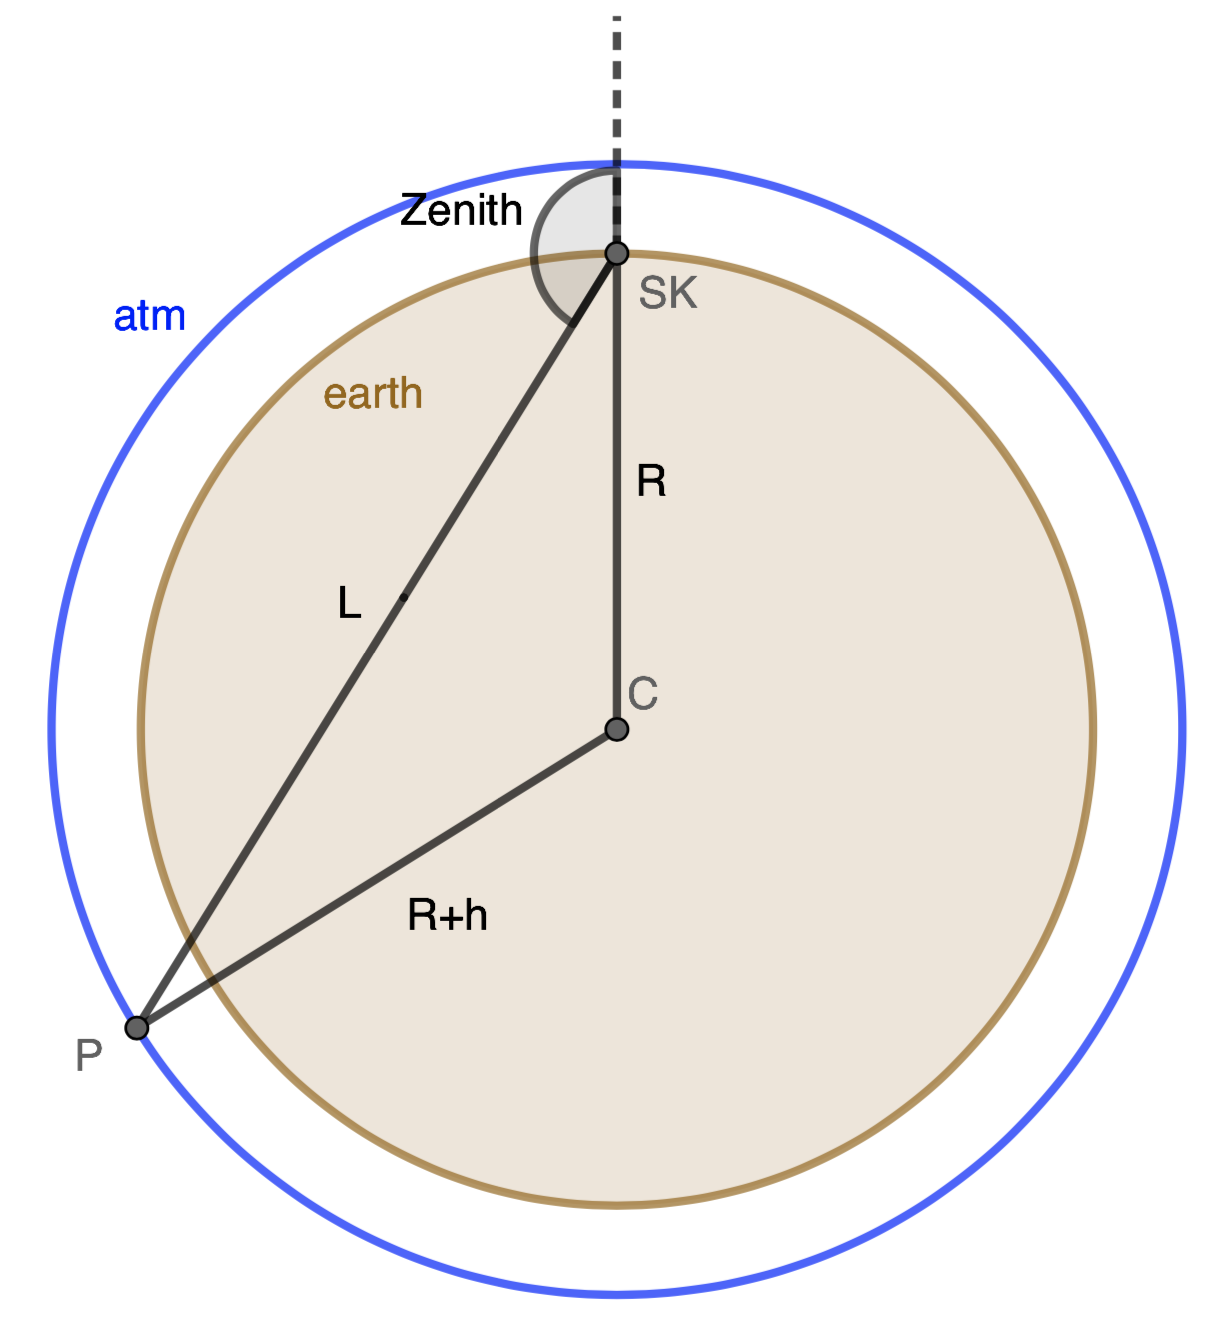

$R$は地球の半径（約6400km）、$h$はニュートリノが大気で生成される高さです（25kmとかですが、図の中では誇張して描いています）。SKが地表にあると考えると、求めたいニュートリノの飛距離$L$は[余弦定理][cosinelaw]から導かれる二次方程式を解くことで求められます：

  [cosinelaw]: http://w3e.kanazawa-it.ac.jp/math/category/sankakukansuu/henkan-tex.cgi?target=/math/category/sankakukansuu/yogenteiri.html

$$
L = - R \cos Z + \sqrt{ (R+h)^2 - R^2 (1 - \cos^2 Z)}
$$

やってみたい人は自分で確認してください。ここでは近似的に解いてみてみましょう。ここで注目すべきは$h$が$R$に対して小さいというところです。実寸で描くと次のようになります：
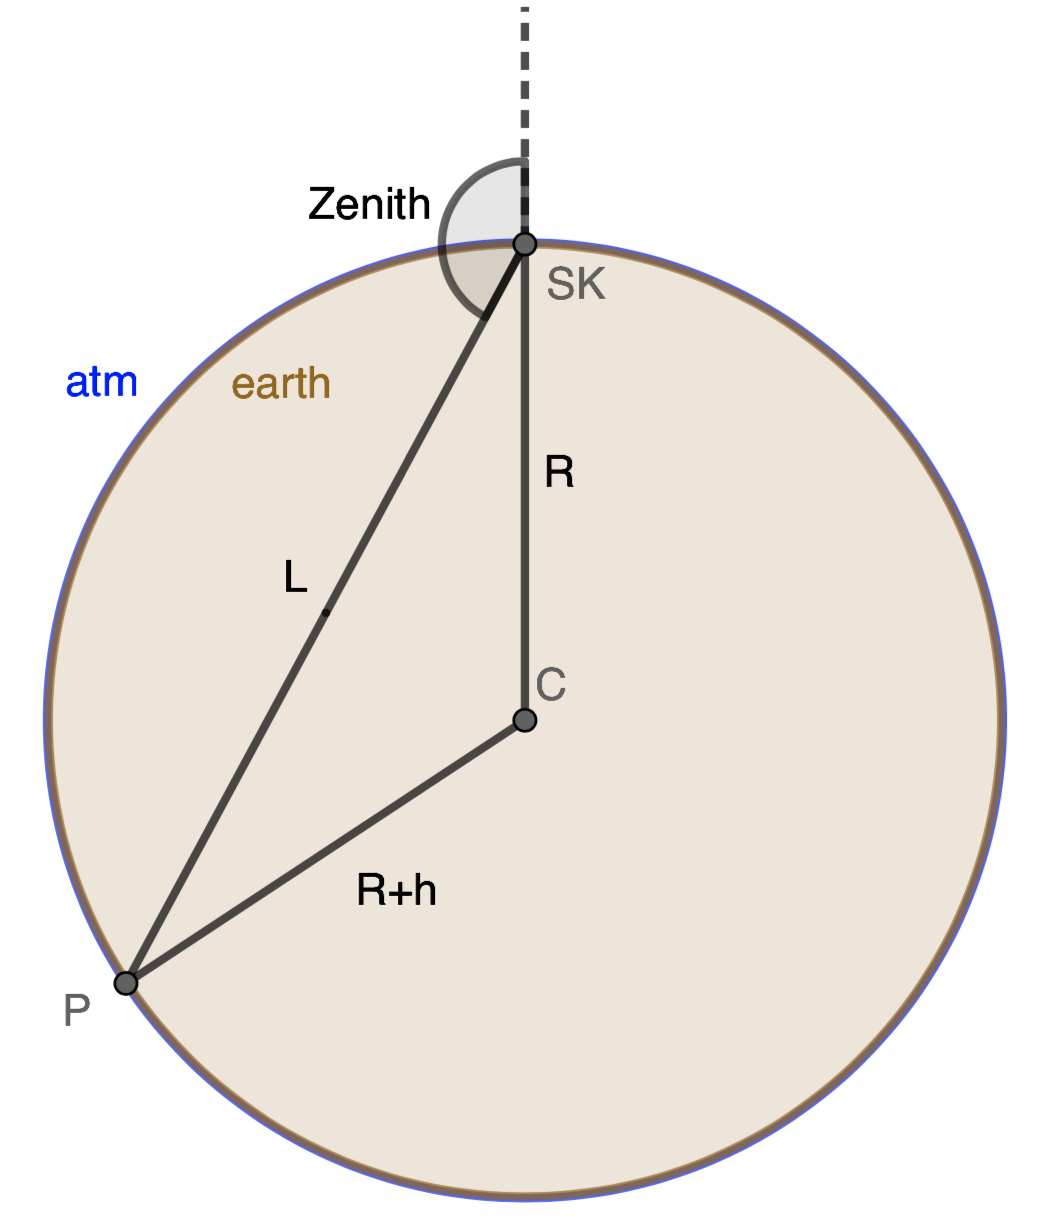

ニュートリノがやや下方向から（地球を通って）来ている場合、$L$は近似的にどのように計算できますか？

次にニュートリノがやや上方向から（地球を通らないで）来ている場合を考えてみましょう。この時$L$は近似的にどのように計算できますか？
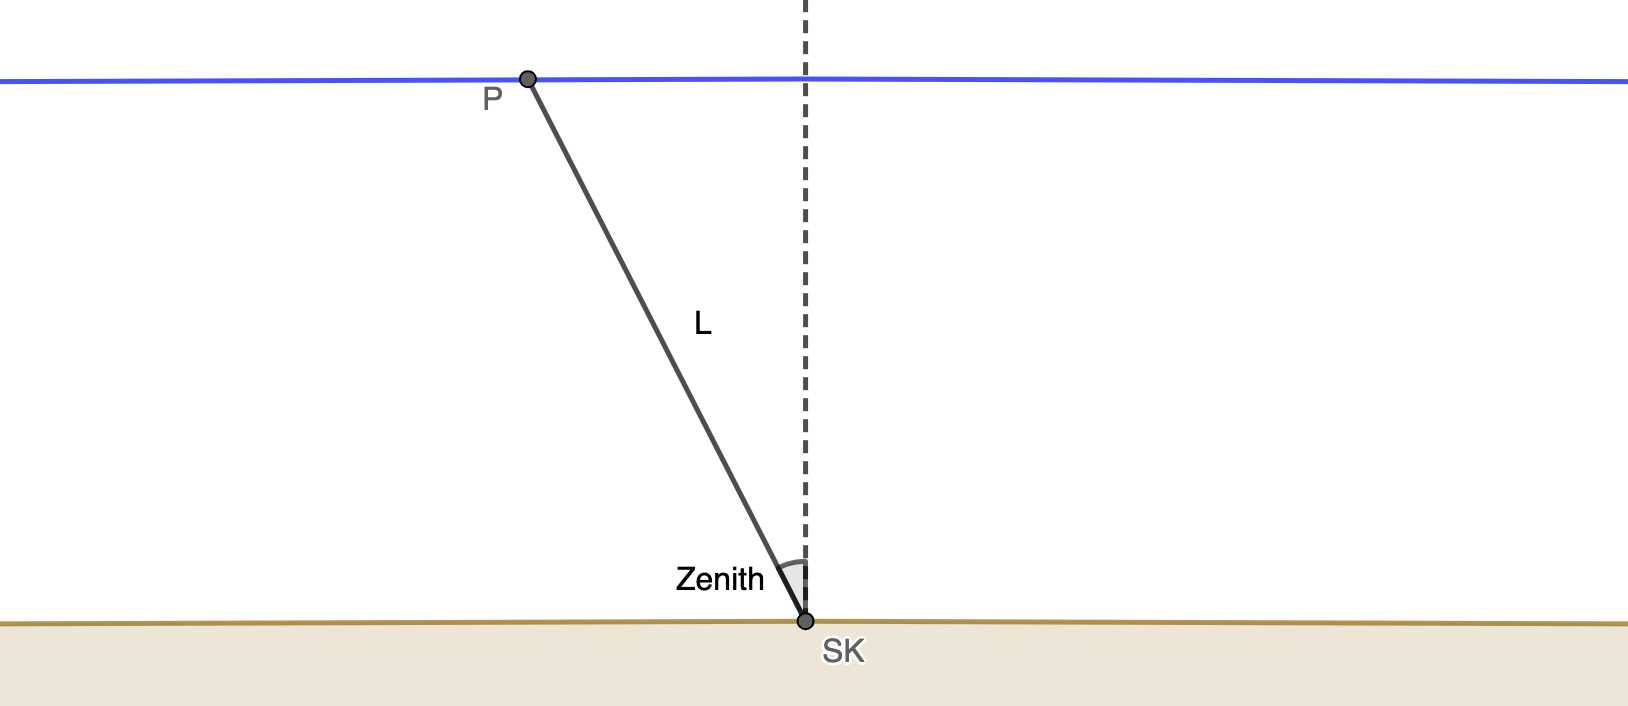

それぞれの式から$L$との関係を図にしてみます：

In [ ]:
h_km = 25.   # 大気におけるニュートリノの生成高度 [km]
R_km = 6400. # 地球の半径 [km]

def GetDistanceTraveled(cosz):
    return(- R_km * cosz + np.sqrt( (R_km+h_km)**2 - R_km**2 * (1. - cosz**2)))

def GetDistanceTraveledApproxUpgoing(cosz): # 下から上に飛んでる時の近似式
    return( 0.*cosz ) # ← 自分で記入してください

def GetDistanceTraveledApproxDowngoing(cosz): # 上から下に飛んでる時の近似式
    return( 0.*cosz ) # ← 自分で記入してください

test_cosZ = np.linspace(-1., 1., 1000) # -1 から 1 まで 1000点
plt.plot(test_cosZ, GetDistanceTraveled               (test_cosZ), label='Exact');
plt.plot(test_cosZ, GetDistanceTraveledApproxUpgoing  (test_cosZ), label='Approx up');
plt.plot(test_cosZ, GetDistanceTraveledApproxDowngoing(test_cosZ), label='Approx down');
plt.xlim(-1.,1.);
plt.ylim(0.,2.*R_km);
plt.xlabel("cos(Zenith)");
plt.ylabel("L [km]");
plt.legend();

上方向、すなわちcos(Zenith)が負の時は計算式あっていそうですね。ここでは$L$がcos(Zenith)と大体負に比例していることが分かります。

水平方向のニュートリノの場合（0付近）はどっちの近似式も崩壊しているようです。

正の時は$L$が0付近に這いつくばってきますが、近似式があっているのかみたいので拡大してみましょう。

In [ ]:
plt.plot(test_cosZ, GetDistanceTraveled               (test_cosZ), label='Exact');
plt.plot(test_cosZ, GetDistanceTraveledApproxUpgoing  (test_cosZ), label='Approx up');
plt.plot(test_cosZ, GetDistanceTraveledApproxDowngoing(test_cosZ), label='Approx down');
plt.xlim(-1.,1.);
plt.ylim(0.,10.*h_km);
plt.xlabel("cos(Zenith)");
plt.ylabel("L [km]");
plt.legend();

OKですね。とにかく距離$L$がずっと小さくてあまり変わらないのがポイントです。こういう大体の計算ができるのは身につけておくと便利な技です。

以降では厳密な式を使いましょう。なので近似式が合わない人もそのまま次に進んでOKです。

ニュートリノ振動の式を書いてみたいので、久世先生のスライドを思い出してみましょう

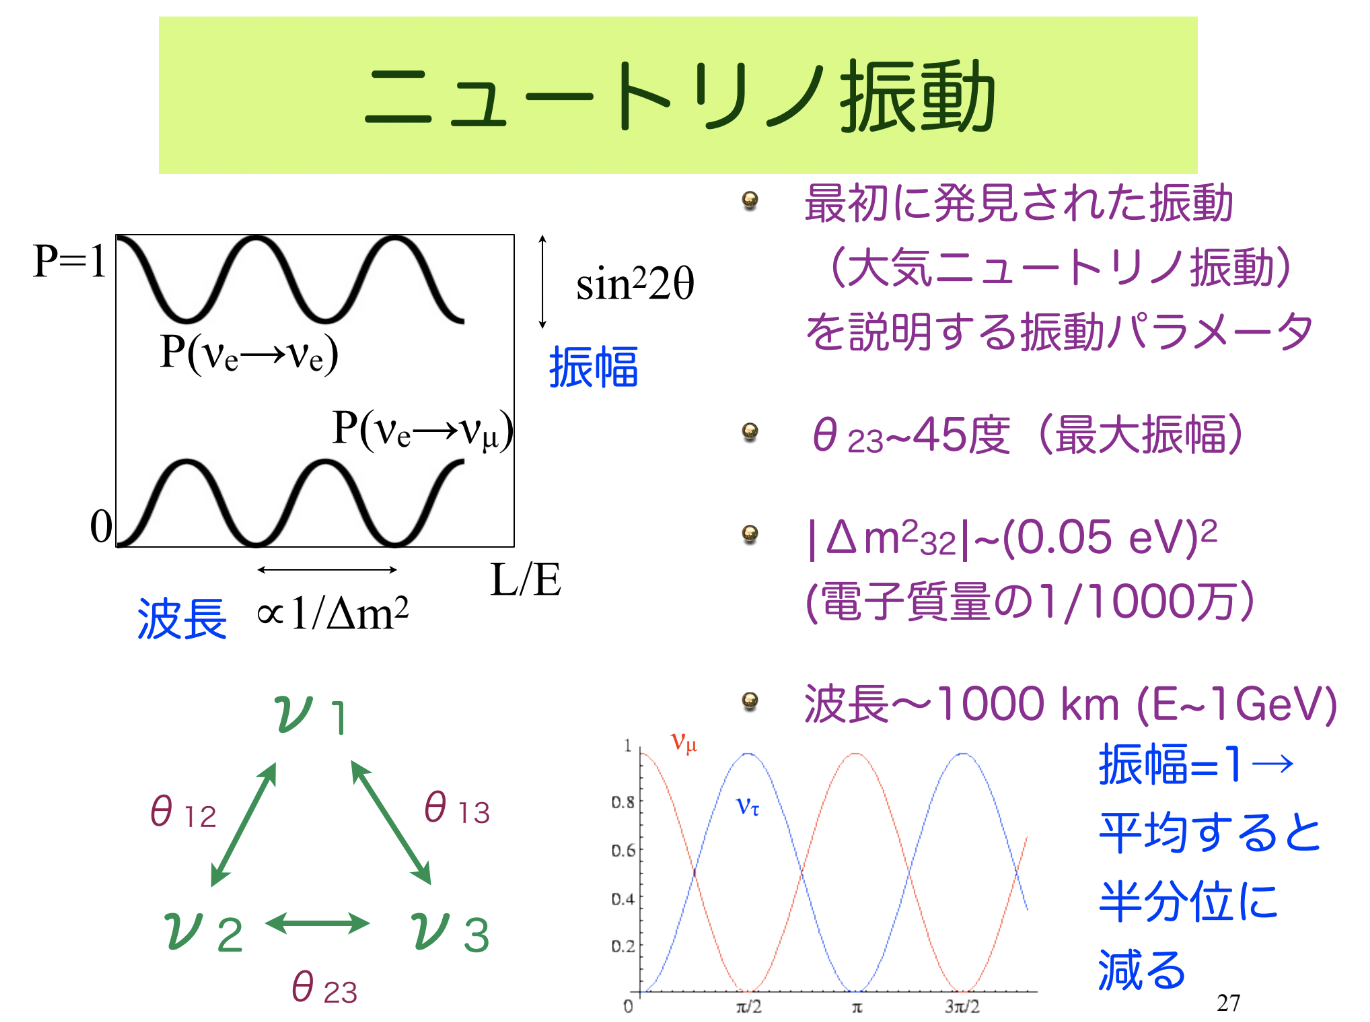

振動の式は以下の通りで、$k$は単なる単位の変換係数です（光の速さとかと関係している）

$$
\begin{align}
P_{\mu \to \mu} &= 1 - \sin^2(2\theta_{23}) \sin^2\left( k \frac{\Delta m^2 L}{E} \right) \\
k &= 1.27 \, \frac{\mathrm{GeV}}{\mathrm{km \, eV^2}}
\end{align}
$$

In [ ]:
dm2_eV2       = (0.05)**2         # μニュートリノとτニュートリノに混合している二つのニュートリノの質量二乗差 [eV^2]
th23          = 45 * (np.pi/180.) # 45度を扱いやすいようにラジアンに変換
k_GeV__km_eV2 = 1.27              # ニュートリノ振動の式で出てくる便利な換算係数 [GeV/km/eV^2]

def GetPmumu(Enu_GeV, L_km):
    return(1. - np.sin(2.*th23)**2 * np.sin(k_GeV__km_eV2 * dm2_eV2 * L_km / Enu_GeV)**2)

# 例えば 3 GeV のニュートリノでみてみましょう。
plt.plot(test_cosZ, GetPmumu(Enu_GeV=3., L_km=GetDistanceTraveled(test_cosZ)));
plt.xlim(-1.,1.);
plt.ylim(0.,1.);
plt.xlabel("cos(Zenith)");
plt.ylabel("P(μ→μ)");

上から来ているニュートリノは飛距離が近いのでほとんど振動しないのに対し、
下から来ているニュートリノは距離が大きく変わるので振動がおき、νμが来ない角度が生じます。
実際の検出器では天頂角やエネルギーがぼやけるので、平均化されて大体半分になります。

材料がそろったのでMC（シミュレーション）に戻ってこちらでも同じことを計算してみましょう。振動するのはνμのCC反応だけなので、  
`mc['truePid'] == TruePid.CC_mu`  
にだけ上の振動確率を計算し、それ以外（NCやνe）は1とします。

In [ ]:
mc['L_km'] = GetDistanceTraveled(mc['trueCosz'])
mc['Posc'] = np.where(mc['truePid'] == TruePid.CC_mu, GetPmumu(mc['trueEnu_GeV'], mc['L_km']), 1.)

In [ ]:
plt.scatter(mc[mc['sample'] == Sample.SubGeV        ]['trueCosz'], mc[mc['sample'] == Sample.SubGeV        ]['recoCosz'], alpha=0.1, label=Sample.SubGeV.name)
plt.scatter(mc[mc['sample'] == Sample.MultiGeV_mlike]['trueCosz'], mc[mc['sample'] == Sample.MultiGeV_mlike]['recoCosz'], alpha=0.1, label=Sample.MultiGeV_mlike.name)
plt.scatter(mc[mc['sample'] == Sample.MultiGeV_elike]['trueCosz'], mc[mc['sample'] == Sample.MultiGeV_elike]['recoCosz'], alpha=0.1, label=Sample.MultiGeV_elike.name)
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.xlabel('True cos(zenith)')
plt.ylabel('Reconstructed cos(zenith)')
plt.legend(loc='lower right');

上で少し説明しましたがSubGeVサンプルはcos(zenith)の再構成精度が悪いです。ここでは捨ててしまいましょう。

In [ ]:
mc_elike = mc[mc['sample'] == Sample.MultiGeV_elike]
mc_mlike = mc[mc['sample'] == Sample.MultiGeV_mlike]

In [ ]:
mcScale = 1.

binEdges = np.linspace(-1., 1., num=10+1)
fig = plt.figure(figsize=(8,6))

n_dt_e = binHist(binEdges, data_elike['recoCosz'])
n_dt_m = binHist(binEdges, data_mlike['recoCosz'])

n_mc_e = binHist(binEdges, mc_elike['recoCosz'], weights=(mc_elike['weight'] * mc_elike['Posc'])*mcScale)
n_mc_m = binHist(binEdges, mc_mlike['recoCosz'], weights=(mc_mlike['weight'] * mc_mlike['Posc'])*mcScale)

n_m0_e = binHist(binEdges, mc_elike['recoCosz'], weights=(mc_elike['weight'])*mcScale)
n_m0_m = binHist(binEdges, mc_mlike['recoCosz'], weights=(mc_mlike['weight'])*mcScale)

# calculate error
n_dt_e_err = np.sqrt(n_dt_e)
n_dt_m_err = np.sqrt(n_dt_m)

n_mc_e_err = np.sqrt(n_mc_e)
n_mc_m_err = np.sqrt(n_mc_m)

# and plot

plotHist(binEdges, n_dt_e, yerr=n_dt_e_err, color="red",   label="e-like, data", linewidth=3)
plotHist(binEdges, n_dt_m, yerr=n_dt_m_err, color="green", label="μ-like, data", linewidth=3)

plotHist(binEdges, n_mc_e, color="red",   label="e-like, MC", linewidth=1)
plotHist(binEdges, n_mc_m, color="green", label="μ-like, MC", linewidth=1)

# wHist(binEdges, data_elike['recoCosz'], color="red",   label="e-like, data", linewidth=3)
# wHist(binEdges, data_mlike['recoCosz'], color="green", label="μ-like, data", linewidth=3)
# 
# wHist(binEdges, mc_elike['recoCosz'], (mc_elike['weight'] * mc_elike['Posc']), errscale=0., color="red",   label="e-like, MC", linewidth=1)
# wHist(binEdges, mc_mlike['recoCosz'], (mc_mlike['weight'] * mc_mlike['Posc']), errscale=0., color="green", label="μ-like, MC", linewidth=1)

plt.ylim([0.,300.])
plt.legend();

全体的なスケールがdataとMCで合わないので、`mcScale`の値を調整してみてください。大気中で発生しているニュートリノ生成反応の総数の不定性によるもので、μニュートリノとeニュートリノは同じ一連の反応で生成されることから、数は一緒に上下します。この後mcScaleは効いてこないので、頑張って調整しなくても大丈夫です（0にだけしないでください）。形が大体合うことは確認できたと思います。

ニュートリノ振動がある時と無い時を比べてみましょうか。ニュートリノ振動の式を使った数が`n_mc_..`、式を使わないで計算した式が`n_m0_..`です。

In [ ]:
fig = plt.figure(figsize=(5,3))

plotHist(binEdges, n_m0_e, color="red",   label="no-osc", linewidth=3)
plotHist(binEdges, n_mc_e, color="red",   label="osc", linewidth=1)

plt.title('e-like')
plt.ylim([0.,250.])
plt.legend();


fig = plt.figure(figsize=(5,3))

plotHist(binEdges, n_m0_m, color="green", label="no-osc", linewidth=3)
plotHist(binEdges, n_mc_m, color="green", label="osc", linewidth=1)

plt.title('μ-like')
plt.ylim([0.,250.])
plt.legend();

振動がある時（細い線）、μ-likeなイベントは下方向から来ているものに関して数が半分ほどになっているのが見えます。

さて先ほど説明したように電子ニュートリノとμニュートリノは同じ過程で作られるので、天頂角に依存した不定性を消すために$Q = μ/e$という数の比率を見てみましょう。

In [ ]:
Q_dt = n_dt_m / n_dt_e
Q_mc = n_mc_m / n_mc_e
Q_m0 = n_m0_m / n_m0_e

Q_dt_err = np.sqrt((n_dt_m_err/n_dt_m)**2 + (n_dt_e_err/n_dt_e)**2) * Q_dt
Q_mc_err = np.sqrt((n_mc_m_err/n_mc_m)**2 + (n_mc_e_err/n_mc_e)**2) * Q_mc


fig = plt.figure(figsize=(8,6))

plotHist(binEdges, Q_dt, yerr=Q_dt_err, label="data", linewidth=3)
plotHist(binEdges, Q_mc, yerr=0.,       label="MC",   linewidth=3)
plotHist(binEdges, Q_m0, yerr=0.,       label="MC, no-osc", linewidth=1)

plt.ylim([0.,2.5])
plt.xlabel('Reconstructed cos(zenith)')
plt.ylabel('Q')
plt.legend();

緑がニュートリノ振動がない時のQなのですが、形があるので、ここではさらに

$$R_i = \frac{Q_i}{Q_\text{MC,no-osc}} \qquad (i \in \{\text{data},\text{MC}\})$$

を定義して、ニュートリノ振動がないなら1、あるなら<1みたいな量にしてみましょう。この量はだいたい$P_{\mu\to\mu}$の振動確率を平均化したものになるので、それも描いてみましょう：

In [ ]:
R_dt = Q_dt / Q_m0
R_mc = Q_mc / Q_m0

R_dt_err = Q_dt_err / Q_m0
R_mc_err = Q_mc_err / Q_m0


fig = plt.figure(figsize=(8,6))

plotHist(binEdges, R_dt, yerr=R_dt_err, label="data", linewidth=3)
plotHist(binEdges, R_mc, yerr=0.,       label="MC",   linewidth=3)

pred_cosz = np.linspace(-1., 1., 800)
pred_L_km = GetDistanceTraveled(pred_cosz)
pred_Enu_GeV = 2.
pred_Pmumu = GetPmumu(pred_Enu_GeV, pred_L_km)
plt.plot(pred_cosz, pred_Pmumu, linewidth=1, label="Pμ→μ")

plt.ylim([0.,1.6])
plt.xlabel('Reconstructed cos(zenith)')
plt.ylabel('R')
plt.legend();

MCとdataが合うように$\theta_{23}$と$\Delta m^2$を調整してみましょう。またどれだけズレているかを定量的に評価するため、各binにおけるdataとMCの差を、期待される$R$の誤差$\epsilon$と比較して何倍かをみていきます。そのまま差を使うと±の平均が0になっていくので、差の二乗を足してきます：
$$
\chi^2 = \sum_{\mathrm{bin}\; i} \left[ \frac{R^\mathrm{data}_i - R^\mathrm{MC}_i}{\epsilon^\mathrm{MC}_i} \right]^2
$$
$\chi$はカイと読みます。$\chi^2$が0の時完璧な一致となりますが、統計的なふらつきがあるので、だいたいビンの数と同程度の値（ここでは10±5くらい）になります。次の図のタイトルのところに$\chi^2$の値を書くのでそれとかdataとMCの一致をみながら$\theta_{23}$と$\Delta m^2$を調整してみてください。ちなみに`data02`の場合大体17くらいが一番小さい値になります。

In [ ]:
# まずこの後なんども同じ計算をするので途中計算を全部まとめてしまいましょう

def predictR():
    # 振動確率を計算
    mc['Posc'] = np.where(mc['truePid'] == TruePid.CC_mu, GetPmumu(mc['trueEnu_GeV'], mc['L_km']), 1.)

    # n, Q, R を順に計算
    selection = (mc['sample'] == Sample.MultiGeV_elike)
    n_mc_e = binHist(binEdges, mc['recoCosz'][selection], weights=(mc['weight'] * mc['Posc'] * mcScale)[selection]);

    selection = (mc['sample'] == Sample.MultiGeV_mlike)
    n_mc_m = binHist(binEdges, mc['recoCosz'][selection], weights=(mc['weight'] * mc['Posc'] * mcScale)[selection]);

    n_mc_e_err = np.sqrt(n_mc_e)
    n_mc_m_err = np.sqrt(n_mc_m)

    Q_mc = n_mc_m / n_mc_e
    Q_mc_err = np.sqrt((n_mc_m_err/n_mc_m)**2 + (n_mc_e_err/n_mc_e)**2) * Q_mc

    R_mc     = Q_mc     / Q_m0
    R_mc_err = Q_mc_err / Q_m0
    
    return (R_mc, R_mc_err)

def plotPosc():
    pred_cosz = np.linspace(-1., 1., 800)
    pred_L_km = GetDistanceTraveled(pred_cosz)
    pred_Enu_GeV = 2.
    pred_Pmumu = GetPmumu(pred_Enu_GeV, pred_L_km)
    plt.plot(pred_cosz, pred_Pmumu, linewidth=1, label="Pμ→μ")

In [ ]:
# ニュートリノ振動のパラメータ .. 調整してみてください
dm2_eV2 = 5e-3
th23 = 1.

# 振動パラメータを使ってMCのRを計算
R_mc, R_mc_err = predictR()

# χ2 を計算
chi2 = sum((R_dt-R_mc)**2/R_mc_err**2)

# プロット
fig = plt.figure(figsize=(8,6))
plotHist(binEdges, R_dt, yerr=R_dt_err, label="data", linewidth=3)
plotHist(binEdges, R_mc, yerr=0.,       label="MC",   linewidth=3)
plotPosc();

plt.ylim([0.,1.6])
plt.xlabel('Reconstructed cos(zenith)')
plt.ylabel('R')
plt.title("χ2 = %g" % chi2)
plt.legend();

せっかくパソコンがあるので自動的に総当たりで色々試してみてもらいましょう。実は$\theta_{23}$の中には同じ結果になる値がいくつかあるので（角度だから例えば360º回すと同じ値になる）。$\sin^2(2\theta_{23})$を0から1まで試すと全部網羅できます。$\Delta m^2$はさっきの値をそのまま使います。

In [ ]:
oa = []
for sin22th23 in np.linspace(0., 1., 40):
    th23 = np.arcsin(np.sqrt(sin22th23))/2.
    
    # 振動パラメータを使ってMCのRを計算
    R_mc, R_mc_err = predictR()
    
    # χ2 を計算
    chi2 = sum((R_dt-R_mc)**2/R_mc_err**2)
    oa.append([sin22th23, chi2])

# 10秒くらいかかります
oa = pd.DataFrame(oa, columns=['sin22th23','chi2'])

結果の中身をみてみましょう

In [ ]:
oa

In [ ]:
# plot

plt.plot(oa['sin22th23'], oa['chi2'])
plt.xlabel('sin2(2θ)')
plt.ylabel('χ2')
plt.xlim(0., 1.)
plt.ylim(0., 60.);
plt.title('Minimum χ2 = %.2f at sin2(2θ) = %.2f' % (np.min(oa['chi2']), oa['sin22th23'][oa['chi2'] == np.min(oa['chi2'])]));

$\Delta m^2$の値にもよりますが、$\sin^22\theta = 0.8$くらいが良さそうです（`data02`の場合）。
ただし多少ずれていてもデータのばらつきを考慮すると信頼できそうな値といえます。

この$\chi^2$の最小値との差を$\Delta \chi^2$と定義すると、信頼区間が求められます（Wilkの定理）。以下の表のように求められます：（ここでは$\theta$だけを見ているので1自由度です）

1自由度の場合：

信頼度 | Δχ2 
------|-----
68.3% | 1 = (1σ)^2
95.5% | 4 = (2σ)^2
99.7% | 9 = (3σ)^2
99.99994% | 25   = (5σ)^2


2自由度の場合：

信頼度 | Δχ2
------|----
68.3% | 2.3
90%   | 4.6

In [ ]:
oa['dchi2'] = oa['chi2'] - np.min(oa['chi2'])

plt.plot(oa['sin22th23'], oa['dchi2'])
plt.xlabel('sin2(2θ)')
plt.ylabel('Δχ2')
plt.axhline(1., linewidth=1, linestyle='--')
plt.axhline(4., linewidth=1, linestyle='--')
plt.xlim(0., 1.)
plt.ylim(0., 25.);

`sin22th23 = 0` の場合ニュートリノ振動がないわけですが、0でのΔχ2 > 25なので、5σ以上で帰無仮定（ニュートリノ振動がない）を棄却できたことになります。ちなみにだからといってニュートリノ振動であるという証明にはならないです。例えばμニュートリノだけ崩壊する、みたいな物理でもデータを説明できるかもしれない。その場合$P_{\mu\to\mu} = \exp[-L/\lambda]$のような指数関数的な減衰とおいて、$\lambda$を使った解析をやってみてください（興味のある人はどうぞ）。

先ほどのbest-fitの値をグラフで見てみましょう

In [ ]:
sin22th23 = oa['sin22th23'][oa['chi2'] == np.min(oa['chi2'])].values[0]
th23 = np.arcsin(np.sqrt(sin22th23))/2.

R_mc, R_mc_err = predictR()

fig = plt.figure(figsize=(8,6))
plotHist(binEdges, R_dt, yerr=R_dt_err, label="data", linewidth=3)
plotHist(binEdges, R_mc, yerr=0.,       label="MC", linewidth=3)
plotPosc()

plt.xlim([-1.,1.])
plt.ylim([0.,1.6])
plt.xlabel('Reconstructed cos(zenith)')
plt.ylabel('R')
plt.legend();

ちなみにΔχ2を計算したときに最小値を引き算して捨てましたが、この値が大きすぎるとモデルがデータとよく合わないという解釈になります。

同じように$\Delta m^2$も最適化できます

In [ ]:
oa = []
sin22th23 = 0.82 # 先ほどの値に調整してください
for dm2_eV2 in np.logspace(-4, -1, 40):
    th23 = np.arcsin(np.sqrt(sin22th23))/2.
    
    R_mc, R_mc_err = predictR()
    
    chi2 = sum((R_dt-R_mc)**2/R_mc_err**2)
    oa.append([dm2_eV2, chi2])

oa = pd.DataFrame(oa, columns=['dm2_eV2','chi2'])

In [ ]:
oa['dchi2'] = oa['chi2'] - np.min(oa['chi2'])

plt.plot(oa['dm2_eV2'], oa['dchi2'])
plt.xlabel('Δm2 [eV2]')
plt.ylabel('Δχ2')
plt.xscale('log')
plt.title('Minimum χ2 = %.2f at Δm2 = %.1e eV2' % (np.min(oa['chi2']), oa['dm2_eV2'][oa['chi2'] == np.min(oa['chi2'])]))
plt.ylim(0., 25.);

In [ ]:
# 今までのbest-fitを入れる
sin22th23 = 1.
dm2_eV2 = 5e-03

th23 = np.arcsin(np.sqrt(sin22th23))/2.
R_mc, R_mc_err = predictR()

fig = plt.figure(figsize=(8,6))
plotHist(binEdges, R_dt, yerr=R_dt_err, label="data", linewidth=3)
plotHist(binEdges, R_mc, yerr=0.,       label="MC", linewidth=3)
plotPosc()

plt.xlim([-1.,1.])
plt.ylim([0.,1.6])
plt.xlabel('Reconstructed cos(zenith)')
plt.ylabel('R')
plt.legend();

$\theta$と$\Delta m^2$を同時に探すことはできないのかと思った人：もちろん可能です（計算に数分時間がかかります）

In [ ]:
oa = []
oa_Nrc = 30

for sin22th23 in np.linspace(0.5, 1., oa_Nrc):
    for dm2_eV2 in np.logspace(-4, -1.5, oa_Nrc):
        th23 = np.arcsin(np.sqrt(sin22th23))/2.
        R_mc, R_mc_err = predictR()

        chi2 = sum((R_dt-R_mc)**2/R_mc_err**2)
        oa.append([sin22th23, dm2_eV2, chi2])

oa = pd.DataFrame(oa, columns=['sin22th23', 'dm2_eV2','chi2'])

In [ ]:
oa['dchi2'] = oa['chi2'] - np.min(oa['chi2'])
oa_bestfit = oa[oa['chi2'] == np.min(oa['chi2'])]

def to2D(pandasColumn, shape):
    return np.reshape(pandasColumn.to_numpy(), shape)

fig = plt.figure(figsize=(8,6))

shape = (oa_Nrc,oa_Nrc)
cp = plt.contour(to2D(oa['sin22th23'], shape), to2D(oa['dm2_eV2'], shape), to2D(oa['dchi2'], shape),
                 levels=[2.28, 4.61], colors=['red','green']) # この 2.28, 4.61 の値は2自由度のχ2の値

cp_fmt = {}
cp_level_strs = ['68%', '90%']
for l, s in zip(cp.levels, cp_level_strs):
    cp_fmt[l] = s

plt.clabel(cp, cp.levels, inline=True, fmt=cp_fmt, fontsize=10)
plt.scatter(oa_bestfit['sin22th23'], oa_bestfit['dm2_eV2'], marker='+', label='Best-fit')
plt.xlim(0., 1.)
plt.ylim(1e-4, 1e-1)
plt.xlabel('sin2(2θ)')
plt.ylabel('Δm2 [eV2]')
plt.legend()
plt.yscale('log');

いままでのはある仮想的な宇宙での模擬データを使ったのですが、例えばSuperKamiokandeによる実際の論文の結果は以下の通りです：

ノーベル賞に繋がった [Phys.Rev.Lett. 81, 1562 (1998)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.81.1562) から抜粋

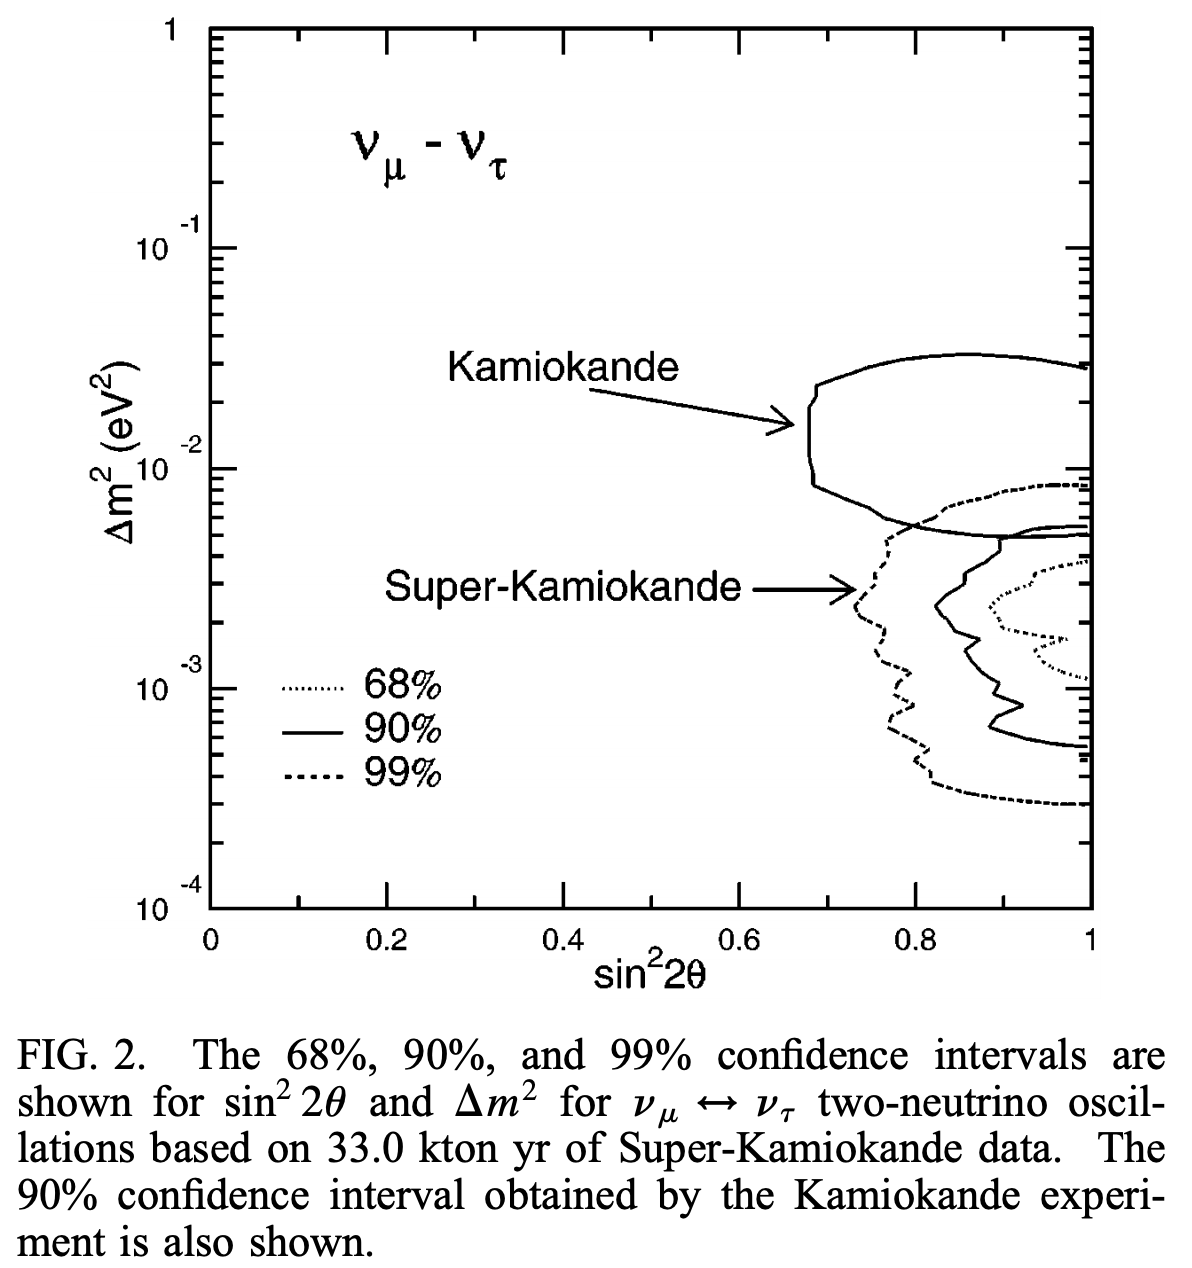

僕たちの住んでいる宇宙においては$\sin^22\theta$が1にかなり近いことが分かります。ちなみに1ではないかはまだはっきり分かっていません。

演習は以上ですが、一応興味あるならさらに遊べるようにいくつかのネタがあります。

- 先にも書いたようにニュートリノの減衰でもデータを説明できるか
- 今cosZenithでbin分けしましたが、代わりにrecoEnergyでやってみる、あるいはrecoEnergyとcosZenithの2次元でやってみる
- 1.5GeV以下のニュートリノは抜いていますが、これらからもニュートリノ振動に対する情報が取り出せるかやってみたいなら、cosZじゃなくてenergyでビン分けして、R=e/μみたいな比ではなくて直接ビンごとのイベント数$n$を使って解析します。そうなると`mcScale`を解析に入れないといけないので、例えば$\Delta m^2$と`mcScale`を2次元で振りながら$\chi^2$を計算して解析します。この場合`mcScale`は系統誤差を表すパラメータとなります。振動パラメータの誤差は`mcScale`を動かすことでより大きくなります。
- SubGeVに関してもe/μに分ければ`mcScale`はいらなくなりますが、`recoPidParam`の分布がMCとデータでずれているので、これを表現できる系統誤差を定義する必要があります。CCeとNCはそれなりに似ているので、例えば`truePid`がCCμのものに関して`recoPidParam`の値を定数分だけずらすパラメータを導入し、これをさっきの`mcScale`みたいに見たい振動パラメータと2次元フィットします。ちなみに実際の検出器よりもPIDの性能をかなり悪くしてあるのでこういう補正が必要なだけで、実際はこれほど強くは効いてきません。
- 今の総当たり作戦だとパラメータを増やすとすごく時間かかるので、minimizerを使って$\chi^2$を最小化するというアプローチがよく使われます。その場合、例えば$\theta$をいくつかの固定の値にとっておいて、$\Delta m^2$とか系統誤差のパラメータを最小化します。